In [ ]:
import os
import json 
import torch 
import torchvision 
import numpy as np 
from src.vggExplainer import VGGExplaner
from omegaconf import OmegaConf 
from src.data import preprocess

# ============================================
# change!
data_path = "/data3/bumjin_data/ILSVRC2012_val"
testset = torchvision.datasets.ImageNet(root=data_path, split="val")
# ============================================

model = torchvision.models.vgg16(pretrained=True)
model.to("cuda:0")
model.eval()
vggEx = VGGExplaner(model, preprocess, register_hook=True)

In [2]:

# ===================================
# Which CNN layer / CNN filter index / samples?
layer = 0
conept_ids = [43,44,45,46]
samples = [5373, 5568, 5367, 5396, 5357] + [5586,5577,1411,5494,3391]
# ===================================
assert 0<= layer <=12

dict = {f"{c_id}_crp":[] for c_id in conept_ids}
lrp_list = []


for data_index in samples:
    img, y = testset[data_index]
    x = preprocess(img).squeeze(0).cuda()
    lrps = vggEx.compute_lrp(x, 5, class_specific=True)[::-1]   # from Relevance 0,1,2,3,...
    lrp = lrps[0].squeeze(0)
    lrp_list.append(lrp)


for c_id in conept_ids:
    concept_masks = [[],[],[],[],[], [],[],[],[],[], [],[]]
    concept_masks[layer].append(c_id)
    for data_index in samples:
        img, y = testset[data_index]
        x = preprocess(img).squeeze(0).cuda()

        # --- Register CRP Mask 
        current_conv_layer = 0
        modules = vggEx.lrp_model.lrp_modules[::-1]     # from Layer 0,1,2,3,...
        for i in range(len(modules)):
            if modules[i].__class__.__name__ in ["Conv2dLrp"]: 
                modules[i].register_concept_mask(concept_masks[current_conv_layer])
                current_conv_layer +=1

        crps = vggEx.compute_lrp(x, 5, class_specific=True)[::-1]   # from Relevance 0,1,2,3,...
        crp = crps[0].squeeze(0)
        dict[f"{c_id}_crp"].append(crp)

        # --- remove CRP mask
        for i in range(len(modules)):
            if modules[i].__class__.__name__ in ["Conv2dLrp"]: 
                modules[i].remove_concept_mask()


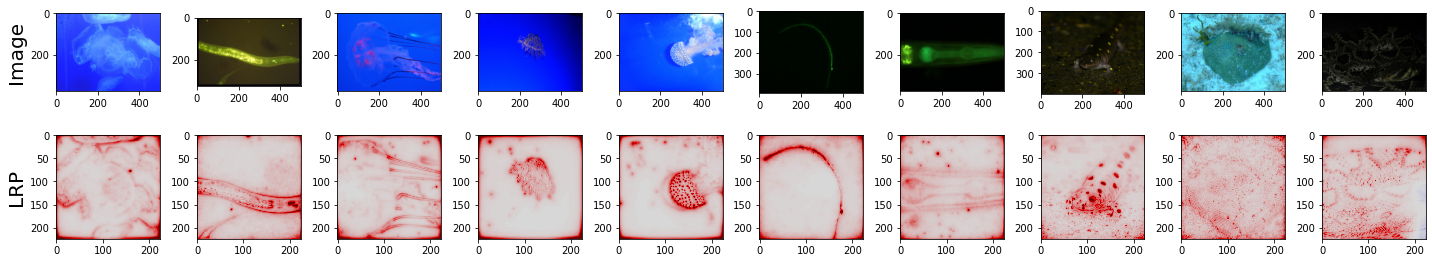

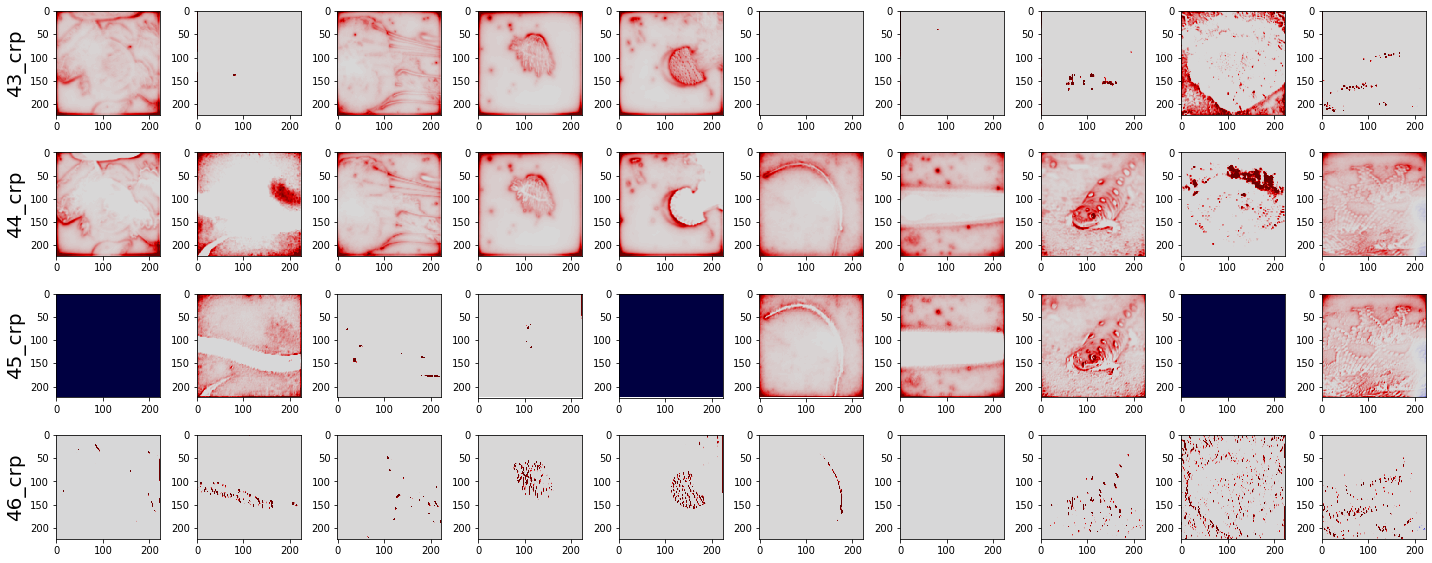

In [3]:
import matplotlib.pyplot as plt 
from src.lrp import process_lrp_before_imshow


# === Plot Image and LRP ===
fig, axes = plt.subplots(2, len(samples), figsize=(20,4), facecolor="white")
for i, index in enumerate(samples):
    img = testset[index][0]
    axes[0,i].imshow(img)
for j in range(len(samples)):
    item = lrp_list[j]
    item = item.permute(1,2,0).cpu().detach().numpy()
    R = item.sum(axis=-1)
    R, kwargs = process_lrp_before_imshow(R)
    axes[1,j].imshow(R, **kwargs)

axes[0,0].set_ylabel("Image", fontsize=20)
axes[1,0].set_ylabel("LRP",  fontsize=20)
plt.tight_layout()

# === Plot CRP ===
fig, axes = plt.subplots(len(conept_ids), len(samples), figsize=(20,len(conept_ids)*2), facecolor="white")
keys = list(dict.keys())
for i, key in enumerate(keys):
    for j, item in enumerate(dict[key]):
        item = item.permute(1,2,0).cpu().detach().numpy()
        R = item.sum(axis=-1)
        R, kwargs = process_lrp_before_imshow(R)
        axes[i,j].imshow(R, **kwargs)
        axes[i,0].set_ylabel(key, fontsize=20)
plt.tight_layout()